In [12]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import xgboost as xgb
import optuna

from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski, MACCSkeys, AllChem

import warnings
warnings.filterwarnings('ignore')


In [13]:

# 기존 데이터 로드
print("기존 데이터 로딩 중...")
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission = pd.read_csv("sample_submission.csv")

print(f"기존 훈련 데이터 : {train.shape}")

# PubChem 데이터 로드
pubchem_data = pd.read_csv("pubchem_cyp3a4_data.csv")

# 필요한 컬럼만 선택
pubchem_processed = pubchem_data[['PUBCHEM_EXT_DATASOURCE_SMILES', 'Activity at 11.43 uM']].copy()

# 컬럼명 변경
pubchem_processed.columns = ['Canonical_Smiles', 'Inhibition']

# 새로운 ID 생성
pubchem_processed['ID'] = ['PUB_' + str(i) for i in range(len(pubchem_processed))]

# 컬럼 순서 맞추기
pubchem_processed = pubchem_processed[['ID', 'Canonical_Smiles', 'Inhibition']]

# 결측치 제거
pubchem_processed = pubchem_processed.dropna()

# Inhibition을 숫자로 변환
pubchem_processed['Inhibition'] = pd.to_numeric(pubchem_processed['Inhibition'], errors='coerce')

# 변환 후 다시 결측치 제거 (변환 실패한 것들)
pubchem_processed = pubchem_processed.dropna()

# 저해율 범위 확인 (0-100%)
pubchem_processed = pubchem_processed[
    (pubchem_processed['Inhibition'] >= 0) & 
    (pubchem_processed['Inhibition'] <= 100)
]

# 데이터 합치기
train = pd.concat([train, pubchem_processed], ignore_index=True)

print(f"합친 후 훈련 데이터 : {train.shape}")
print(f"추가된 데이터 수 : {len(pubchem_processed)}")
print(f"Inhibition 데이터 타입: {train['Inhibition'].dtype}")

기존 데이터 로딩 중...
기존 훈련 데이터 : (1681, 3)
합친 후 훈련 데이터 : (24356, 3)
추가된 데이터 수 : 22675
Inhibition 데이터 타입: float64


In [14]:

def get_molecule_descriptors(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return [0] * 2232

        basic_descriptors = [
            Descriptors.MolWt(mol),
            Descriptors.MolLogP(mol),
            Descriptors.NumHAcceptors(mol),
            Descriptors.NumHDonors(mol),
            Descriptors.TPSA(mol),
            Descriptors.NumRotatableBonds(mol),
            Descriptors.NumAromaticRings(mol),
            Descriptors.NumHeteroatoms(mol),
            Descriptors.FractionCSP3(mol),
            Descriptors.NumAliphaticRings(mol),
            Lipinski.NumAromaticHeterocycles(mol),
            Lipinski.NumSaturatedHeterocycles(mol),
            Lipinski.NumAliphaticHeterocycles(mol),
            Descriptors.HeavyAtomCount(mol),
            Descriptors.RingCount(mol),
            Descriptors.NOCount(mol),
            Descriptors.NHOHCount(mol),
            Descriptors.NumRadicalElectrons(mol),
        ]

        morgan_fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
        morgan_features = [int(bit) for bit in morgan_fp.ToBitString()]

        maccs_fp = MACCSkeys.GenMACCSKeys(mol)
        maccs_features = [int(bit) for bit in maccs_fp.ToBitString()]

        all_features = basic_descriptors + morgan_features + maccs_features

        return all_features
    except:
        return [0] * 2232


## 분자 특성 추출 및 데이터 전처리 과정

이 단계에서는 SMILES 문자열을 분자 특성으로 변환하고, 머신러닝 모델에 입력할 수 있는 형태로 데이터를 준비합니다.

### 처리 과정:
1. **특성 추출**: 각 SMILES를 2232차원의 특성 벡터로 변환
2. **길이 통일**: 모든 특성 벡터의 길이를 동일하게 맞춤
3. **배열 변환**: 리스트를 NumPy 배열로 변환
4. **차원 정합**: 훈련/테스트 데이터의 특성 차원을 일치시킴

In [15]:
print("분자 특성 추출 중...")

# 1. 훈련 데이터 특성 추출
# SMILES를 분자 특성으로 변환 (각 행에 대해 get_molecule_descriptors 함수 적용)
train['features'] = train['Canonical_Smiles'].apply(get_molecule_descriptors)

# 2. 훈련 데이터 길이 통일
# features 컬럼의 리스트들을 파이썬 리스트로 변환
X_train_list = train['features'].tolist()
# 각 특성 벡터의 길이 확인
feature_lengths = [len(x) for x in X_train_list]

# 만약 특성 벡터들의 길이가 다르다면 (이론적으로는 모두 2232여야 함)
if len(set(feature_lengths)) != 1:
    max_length = max(feature_lengths)
    # 짧은 벡터들을 0으로 패딩하여 길이를 맞춤
    X_train_list = [x + [0] * (max_length - len(x)) for x in X_train_list]

# 3. NumPy 배열로 변환
X_train = np.array(X_train_list)  # (샘플 수, 특성 수) 형태의 2D 배열
y_train = train['Inhibition'].values  # 타겟 변수

# 4. 테스트 데이터 특성 추출 (훈련 데이터와 동일한 과정)
test['features'] = test['Canonical_Smiles'].apply(get_molecule_descriptors)
X_test_list = test['features'].tolist()
feature_lengths = [len(x) for x in X_test_list]

# 테스트 데이터도 길이 통일
if len(set(feature_lengths)) != 1:
    max_length = max(feature_lengths)
    X_test_list = [x + [0] * (max_length - len(x)) for x in X_test_list]

# 5. 훈련/테스트 데이터 간 차원 정합
# 만약 훈련과 테스트 데이터의 특성 수가 다르다면
if X_train.shape[1] != len(X_test_list[0]):
    diff = abs(X_train.shape[1] - len(X_test_list[0]))
    if X_train.shape[1] > len(X_test_list[0]):
        # 훈련 데이터가 더 크면 테스트 데이터를 패딩
        X_test_list = [x + [0] * diff for x in X_test_list]
    else:
        # 테스트 데이터가 더 크면 훈련 데이터를 패딩
        X_train = np.array([x.tolist() + [0] * diff for x in X_train])

# 6. 최종 테스트 데이터 배열 변환
X_test = np.array(X_test_list)

print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"특성 벡터 구성: 기본 특성(18) + Morgan(2048) + MACCS(166) = 총 {X_train.shape[1]}개")


분자 특성 추출 중...


[19:02:58] DEPRECATION WARNING: please use MorganGenerator
[19:02:58] DEPRECATION WARNING: please use MorganGenerator
[19:02:58] DEPRECATION WARNING: please use MorganGenerator
[19:02:58] DEPRECATION WARNING: please use MorganGenerator
[19:02:58] DEPRECATION WARNING: please use MorganGenerator
[19:02:58] DEPRECATION WARNING: please use MorganGenerator
[19:02:58] DEPRECATION WARNING: please use MorganGenerator
[19:02:58] DEPRECATION WARNING: please use MorganGenerator
[19:02:58] DEPRECATION WARNING: please use MorganGenerator
[19:02:58] DEPRECATION WARNING: please use MorganGenerator
[19:02:58] DEPRECATION WARNING: please use MorganGenerator
[19:02:58] DEPRECATION WARNING: please use MorganGenerator
[19:02:58] DEPRECATION WARNING: please use MorganGenerator
[19:02:58] DEPRECATION WARNING: please use MorganGenerator
[19:02:58] DEPRECATION WARNING: please use MorganGenerator
[19:02:58] DEPRECATION WARNING: please use MorganGenerator
[19:02:58] DEPRECATION WARNING: please use MorganGenerat

X_train: (24356, 2233), X_test: (100, 2233)
특성 벡터 구성: 기본 특성(18) + Morgan(2048) + MACCS(166) = 총 2233개


[19:04:24] DEPRECATION WARNING: please use MorganGenerator
[19:04:24] DEPRECATION WARNING: please use MorganGenerator
[19:04:24] DEPRECATION WARNING: please use MorganGenerator


In [16]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [17]:
# Sample Weighting 함수 정의
def calculate_sample_weights(y_values, high_inhibition_threshold=80, weight_multiplier=3.0):
    """
    고저해율(80~100%) 구간의 샘플에 더 높은 가중치를 부여
    
    Args:
        y_values: 저해율 값들
        high_inhibition_threshold: 고저해율 기준 (기본값: 80%)
        weight_multiplier: 고저해율 샘플에 적용할 가중치 배수 (기본값: 3.0)
    
    Returns:
        sample_weights: 각 샘플의 가중치 배열
    """
    sample_weights = np.ones(len(y_values))
    
    # 고저해율 구간 (80~100%) 샘플에 더 높은 가중치 부여
    high_inhibition_mask = y_values >= high_inhibition_threshold
    sample_weights[high_inhibition_mask] = weight_multiplier
    
    print(f"전체 샘플 수: {len(y_values)}")
    print(f"고저해율 샘플 수 (>={high_inhibition_threshold}%): {np.sum(high_inhibition_mask)}")
    print(f"고저해율 샘플 비율: {np.sum(high_inhibition_mask)/len(y_values)*100:.1f}%")
    print(f"가중치 배수: {weight_multiplier}")
    
    return sample_weights
# 전체 데이터에 대한 샘플 가중치 계산
sample_weights = calculate_sample_weights(y_train, high_inhibition_threshold=80, weight_multiplier=3.0)

X_train_final, X_val, y_train_final, y_val, weights_train_final, weights_val = train_test_split(
    X_train_scaled, y_train, sample_weights, test_size=0.2, random_state=42
)

전체 샘플 수: 24356
고저해율 샘플 수 (>=80%): 257
고저해율 샘플 비율: 1.1%
가중치 배수: 3.0


In [18]:

def normalized_rmse(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse / (np.max(y_true) - np.min(y_true))

def pearson_correlation(y_true, y_pred):
    corr = np.corrcoef(y_true, y_pred)[0, 1]
    return np.clip(corr, 0, 1)

def competition_score(y_true, y_pred):
    nrmse = min(normalized_rmse(y_true, y_pred), 1)
    pearson = pearson_correlation(y_true, y_pred)
    return 0.5 * (1 - nrmse) + 0.5 * pearson

def train_and_evaluate_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    val_nrmse = normalized_rmse(y_val, y_val_pred)
    val_pearson = pearson_correlation(y_val, y_val_pred)
    val_score = competition_score(y_val, y_val_pred)
    print(f"검증 NRMSE: {val_nrmse:.4f}")
    print(f"검증 Pearson: {val_pearson:.4f}")
    print(f"검증 점수: {val_score:.4f}")
    return model, val_score

from sklearn.model_selection import KFold

# Optuna를 위한 objective 함수 정의
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 1500),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 15),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 2.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 5.0),
        'tree_method': 'gpu_hist',
        'gpu_id': 0,
        'random_state': 42,
        'early_stopping_rounds': 100,
        'eval_metric': 'rmse'
    }
    
    model = xgb.XGBRegressor(**params)
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    
    for train_idx, val_idx in kf.split(X_train_scaled):
        X_tr, X_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        weights_tr = sample_weights[train_idx]  # 샘플 가중치도 분할
        
        model.fit(
            X_tr, y_tr,
            sample_weight=weights_tr,  # 샘플 가중치 적용
            eval_set=[(X_val, y_val)],
            verbose=False
        )
        
        y_pred = model.predict(X_val)
        score = competition_score(y_val, y_pred)
        scores.append(score)
    
    return np.mean(scores)


In [19]:
# Optuna 최적화 실행
print("XGBRegressor 하이퍼파라미터 최적화 시작...")
study = optuna.create_study(direction='maximize')  # neg_mean_squared_error를 최대화
study.optimize(objective, n_trials=100)

print(f"최적 파라미터: {study.best_params}")
print(f"최적 점수 (neg_MSE): {study.best_value:.4f}")
print(f"최적 MSE: {-study.best_value:.4f}")

# 최적 하이퍼파라미터로 모델 훈련
best_params = study.best_params
best_params.update({
    'tree_method': 'gpu_hist',
    'gpu_id': 0,
    'random_state': 42,
    'n_jobs': -1
})

best_model = xgb.XGBRegressor(**best_params)
best_model.fit(X_train_final, y_train_final, sample_weight=weights_train_final)

# 검증 데이터로 성능 평가
y_val_pred = best_model.predict(X_val)

val_nrmse = normalized_rmse(y_val, y_val_pred)
val_pearson = pearson_correlation(y_val, y_val_pred)
val_score = competition_score(y_val, y_val_pred)

print(f"\n검증 데이터 성능:")
print(f"검증 NRMSE: {val_nrmse:.4f}")
print(f"검증 Pearson: {val_pearson:.4f}")
print(f"검증 점수: {val_score:.4f}")


[I 2025-07-10 19:04:25,148] A new study created in memory with name: no-name-f60982c5-04e9-4e0e-b552-23e08a22cab2


XGBRegressor 하이퍼파라미터 최적화 시작...


[I 2025-07-10 19:04:49,357] Trial 0 finished with value: 0.4904650034198828 and parameters: {'n_estimators': 598, 'max_depth': 6, 'learning_rate': 0.019015574517575434, 'subsample': 0.9383252988771966, 'colsample_bytree': 0.8688005920317243, 'min_child_weight': 11, 'gamma': 0.25494754354255966, 'reg_alpha': 0.3824115929327665, 'reg_lambda': 2.5722851396283946}. Best is trial 0 with value: 0.4904650034198828.
[I 2025-07-10 19:05:05,397] Trial 1 finished with value: 0.49176252940426635 and parameters: {'n_estimators': 888, 'max_depth': 5, 'learning_rate': 0.0385294208879076, 'subsample': 0.7898063321199049, 'colsample_bytree': 0.7566871768438375, 'min_child_weight': 9, 'gamma': 0.28769600395068606, 'reg_alpha': 1.8477297768937886, 'reg_lambda': 0.46883338363237936}. Best is trial 1 with value: 0.49176252940426635.
[I 2025-07-10 19:05:29,483] Trial 2 finished with value: 0.48929143977630085 and parameters: {'n_estimators': 637, 'max_depth': 9, 'learning_rate': 0.03535798009507749, 'subsam

최적 파라미터: {'n_estimators': 1039, 'max_depth': 8, 'learning_rate': 0.010023346705756817, 'subsample': 0.7308049786478629, 'colsample_bytree': 0.731686783868898, 'min_child_weight': 15, 'gamma': 0.38792919261084824, 'reg_alpha': 1.139846175169176, 'reg_lambda': 4.315514351150011}
최적 점수 (neg_MSE): 0.4974
최적 MSE: -0.4974

검증 데이터 성능:
검증 NRMSE: 0.1664
검증 Pearson: 0.1300
검증 점수: 0.4818


In [20]:
# 최종 모델로 전체 데이터 학습 및 예측
print("\n전체 데이터로 최종 모델 훈련 중 (Sample Weighting 적용)...")
final_model = xgb.XGBRegressor(**best_params)
final_model.fit(X_train_scaled, y_train, sample_weight=sample_weights)




전체 데이터로 최종 모델 훈련 중 (Sample Weighting 적용)...


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.731686783868898
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [21]:
test_preds = final_model.predict(X_test_scaled)

# 결과 저장
submission['Inhibition'] = test_preds
submission.to_csv('xgboost_optuna_submission.csv', index=False)
print("예측 결과 저장: xgboost_optuna_submission.csv")


예측 결과 저장: xgboost_optuna_submission.csv


모델 성능 시각화 저장: xgboost_model_performance.png
특성 중요도 시각화 저장: xgboost_feature_importance.png

최종 결과:
검증 점수: 0.4818


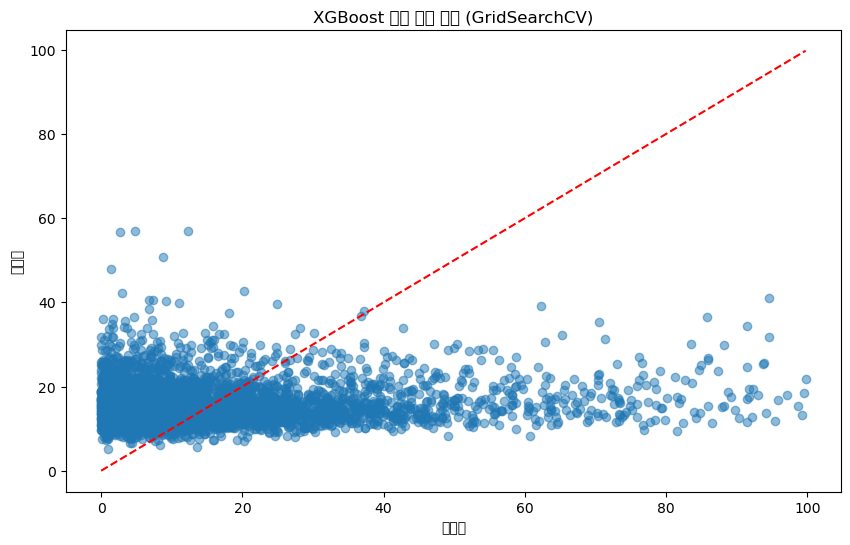

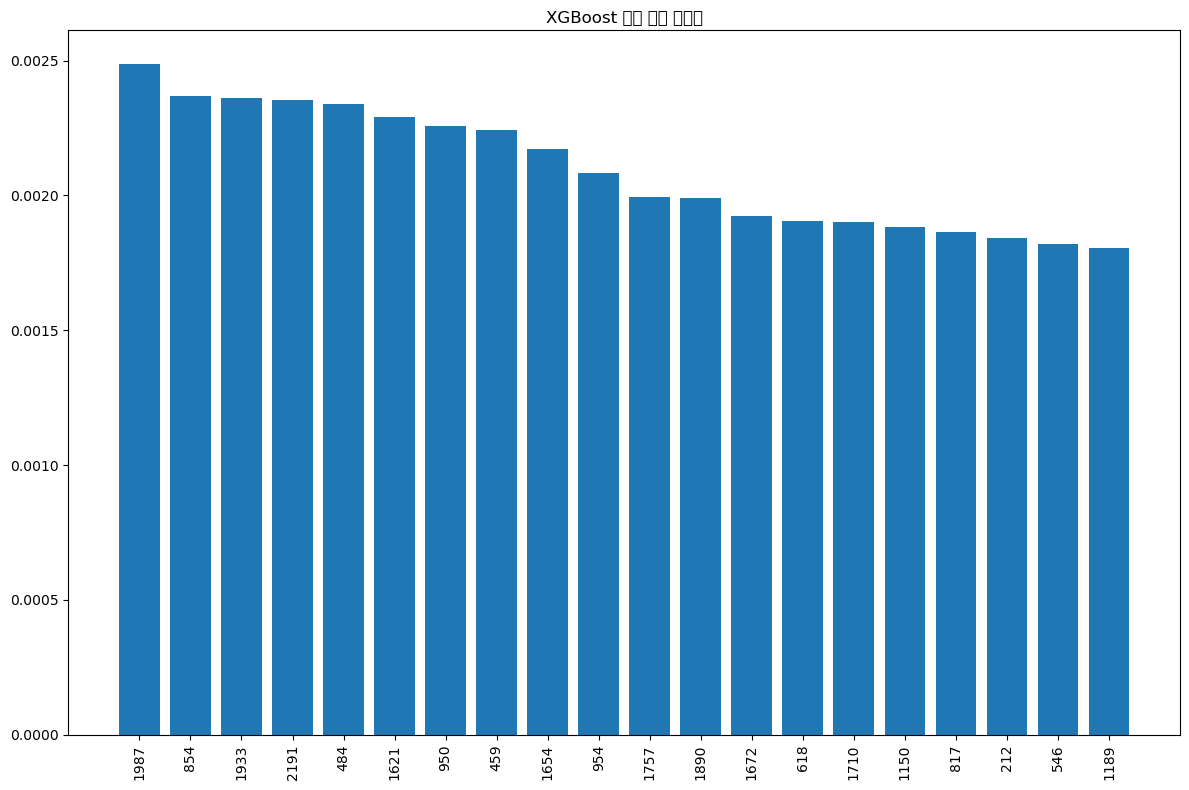

In [22]:
# 시각화
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_val_pred, alpha=0.5)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], 'r--')
plt.xlabel('실제값')
plt.ylabel('예측값')
plt.title('XGBoost 모델 검증 성능 (GridSearchCV)')
plt.savefig('xgboost_model_performance.png')
print("모델 성능 시각화 저장: xgboost_model_performance.png")

# 특성 중요도 시각화
n_features = 20
importances = final_model.feature_importances_
indices = np.argsort(importances)[::-1][:n_features]
plt.figure(figsize=(12, 8))
plt.title('XGBoost 상위 특성 중요도')
plt.bar(range(n_features), importances[indices])
plt.xticks(range(n_features), indices, rotation=90)
plt.tight_layout()
plt.savefig('xgboost_feature_importance.png')
print("특성 중요도 시각화 저장: xgboost_feature_importance.png")

print(f"\n최종 결과:")
print(f"검증 점수: {val_score:.4f}")